In [1]:
import time
import numpy as np
import pandas as pd
from collections import defaultdict
import scipy.sparse as sp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from tqdm import tqdm
import time

In [2]:
path = 'rekko/ratings.csv'
df = pd.read_csv(path)
df = df.iloc[:500, :]

**Посмотрим на данные**

In [3]:
df.head()

,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07
3,359870,1364,10,4.430506e+07
4,359870,3578,9,4.430506e+07


**Возьмем реализацию SVD из одной из домашних работ**

In [4]:
class SVD:
    def __init__(self, optimization_method='sgd', n_factors=10, n_epochs=10, lr_pq=1e-3, 
                 lr_bias=1e-6, biased=True, std_init=1e-1, reg_alpha=1e-2, verbose=True):
        
        if optimization_method not in ['sgd', 'als']:
            print('Incorrect name of optimization method')
            
        self.optimization_method = optimization_method
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr_pq = lr_pq
        self.lr_bias = lr_bias
        self.biased = biased
        self.std_init = std_init
        self.reg_alpha = reg_alpha
        self.verbose = verbose
        
        self.trainset = None
        self.bu = {}
        self.bi = {}
        self.pu = {}
        self.qi = {}
        
    def fit(self, trainset):
        """
        Find pu, qi, mu, bu, bi: 
        r' = mu + bu + bi + pu * qi.
        SGD or ALS can be used for optimization.
        """
        self.trainset = trainset
            
        if self.optimization_method == 'sgd':
            self.sgd()
        else:
            
            df = self.trainset.replace(0, np.NaN)
            self.mu = df.mean(skipna=True, axis=1).mean(axis=0)
            self.biased = False
            
            X, y = self.als()
            X = X.toarray()
            y = y.toarray().T
            
            for u in range(self.trainset.shape[0]):
                u_id = int(self.trainset.index[u])
                for f in range(self.n_factors):
                    self.pu[u_id, f] = X[u, f]
                
            for i in range(self.trainset.shape[1]):
                i_id = int(self.trainset.columns[i])
                for f in range(self.n_factors):
                    self.qi[i_id, f] = y.T[i, f]
                
    def sgd(self):
        """
        Stochastic gradient descent.
        """
        
        if not self.biased:
            self.mu = 0
        else:
            df = self.trainset.replace(0, np.NaN)
            self.mu = df.mean(skipna=True, axis=1).mean(axis=0)
        
        bu = np.zeros(self.trainset.shape[0])
        bi = np.zeros(self.trainset.shape[1])
        pu = np.random.normal(self.mu, self.std_init, (self.trainset.shape[0], self.n_factors))
        qi = np.random.normal(self.mu, self.std_init, (self.trainset.shape[1], self.n_factors))

        for current_epoch in range(self.n_epochs):
            if self.verbose:
                print (f'Processing epoch {current_epoch+1} / {self.n_epochs}')
            for u in range(self.trainset.shape[0]):
                for i in range(self.trainset.shape[1]):
                    r = self.trainset.iloc[u, i]

                    dot = 0
                    for f in range(self.n_factors):
                        dot += qi[i, f] * pu[u, f]
                    err = r - self.mu - dot - bu[u] - bi[i]
                    
                    # update biases
                    if self.biased:
                        bu[u] += self.lr_bias * (err - self.reg_alpha *  bu[u])
                        bi[i] += self.lr_bias * (err - self.reg_alpha *  bi[i])

                    for f in range(self.n_factors):
                        pu[u, f] += self.lr_pq * (err * pu[u, f] - self.reg_alpha * qi[i, f]) 
                        qi[i, f] += self.lr_pq * (err * qi[i, f] - self.reg_alpha * pu[u, f])
      
        for u in range(self.trainset.shape[0]):
            u_id = int(self.trainset.index[u])
            self.bu[u_id] = bu[u]
            for f in range(self.n_factors):
                self.pu[u_id, f] = pu[u, f]
                
        for i in range(self.trainset.shape[1]):
            i_id = int(self.trainset.columns[i])
            self.bi[i_id] = bi[i]
            for f in range(self.n_factors):
                self.qi[i_id, f] = qi[i, f]

    
    def get_svd_embeddings(self):
        """
        Get embedding from SVD decomposition.
        """
        user_embeddings = defaultdict(list)
        item_embeddings = defaultdict(list)
        
        for key in self.pu.keys():
            user_embeddings[key[0]].append(self.pu[key])
        
        for key in self.qi.keys():
            item_embeddings[key[0]].append(self.qi[key])
        
        return user_embeddings, item_embeddings
        
    def predict(self, testset):
        """
        Get predicted rating matrix.
        """

        preds = []
        for u in range(testset.shape[0]):
            u_id = int(self.trainset.index[u])
            known_user = u_id in self.trainset.index
            
            pred = []
            for i in range(testset.shape[1]):
                i_id = int(self.trainset.columns[i])
                known_item = i_id in self.trainset.columns
                
                if self.biased:
                    est = self.mu

                    if known_user:
                        est += self.bu[u_id]

                    if known_item:
                        est += self.bi[i_id]

                    if known_user and known_item:
                        for f in range(self.n_factors):
                            est += self.qi[i_id, f] * self.pu[u_id, f]

                else:
                    est = 0
                    if known_user and known_item:
                        for f in range(self.n_factors):
                            est += self.qi[i_id, f] * self.pu[u_id, f]
                    else:
                        print('User and item are unknown.')
                            
                pred.append(est)

            preds.append(pred)
        preds = pd.DataFrame(preds)
        preds.columns = testset.columns
        preds.index = testset.index
        return preds

**NeuMF:**

In [21]:
class NeuMF(torch.nn.Module):
    def __init__(self, user_embeddings, item_embeddings, num_factors):
        super(NeuMF, self).__init__()
        self.num_factors = num_factors
        
        # Embeddings (latent vectors from SVD decomposition)
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings
        
        MLP_modules = []
        init_size = 2 * self.num_factors
        MLP_modules.append(nn.Linear(init_size, init_size//2)) 
        MLP_modules.append(nn.SELU())
        self.MLP_layers = nn.Sequential(*MLP_modules)
        self.predict_layer = nn.Linear(2*self.num_factors, 1)

    def forward(self, users, items):
        
        user_emds = []
        for el in users:
            if el.item() in self.user_embeddings.keys():
                user_emds.append(torch.tensor(self.user_embeddings[el.item()]))
            else:
                user_emds.append(torch.zeros(self.num_factors))
                
        user_emds_ready = torch.stack(user_emds)
        
        item_emds = []
        for el in items:
            if el.item() in self.item_embeddings.keys():
                item_emds.append(torch.tensor(self.item_embeddings[el.item()]))
            else:
                item_emds.append(torch.zeros(self.num_factors))
        item_emds_ready = torch.stack(item_emds)
        
        # GMF
        output_GMF = user_emds_ready * item_emds_ready
        interaction = torch.cat((user_emds_ready, item_emds_ready), -1).float()
        
        # MLP
        output_MLP = self.MLP_layers(interaction)
        concat = torch.cat((output_GMF, output_MLP), -1).float()
        prediction = self.predict_layer(concat)
        
        return prediction.view(-1)

**Класс NeuMFData для обертки данных в датасет**

In [7]:
class NeuMFData(data.Dataset):
    def __init__(self, features, num_item, matrix=None):
        super(NeuMFData, self).__init__()
        self.features = features
        self.num_item = num_item
        self.matrix = matrix
        self.labels = [matrix.todense()[el[0], el[1]] for el in features]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        user = self.features[idx][0]
        item = self.features[idx][1]
        label = self.labels[idx]
        return user, item, label

In [8]:
# fuction for correct work with dataloader

def collate(batch):
    users = []
    items = []
    labels = []
    for el in batch:
        user, item, label = el
        users.append(user)
        items.append(item)
        labels.append(label)
    return torch.tensor(users, dtype=torch.int64), torch.tensor(items, dtype=torch.int64), torch.tensor(labels, dtype=torch.float64)

In [9]:
# function for load data from dataframe

def load(df):
    user_num = df['user_uid'].max() + 1
    item_num = df['element_uid'].max() + 1
    
    matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for i in tqdm(range(df.shape[0])):
        user_id = df.iloc[i, :]['user_uid']
        item_id = df.iloc[i, :]['element_uid']
        rating = df.iloc[i, :]['rating']
        matrix[user_id, item_id] = rating

    return df.iloc[:, :2].values.tolist(), user_num, item_num, matrix

**Функция для подсчета RMSE**

In [10]:
def rmse(y_1, y_2):
    y_1_ = y_1.detach().numpy()
    y_2_ = y_2.detach().numpy()
    return ((y_1_ - y_2_) ** 2).mean() ** .5


def get_metrics(model, test_loader, top_k=3):
    RMSE_metric = []

    for user, item, label in test_loader:

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).numpy().tolist()
        gt_item = item[0].item()

        RMSE_metric.append(rmse(predictions, label))

    return np.mean(RMSE_metric)

**Кросс-валидация по 3-м фолдам**

In [11]:
def validate(model_name, df, dataset, n_epochs, n_splits=3, 
             factor_num=8, batch_size=10, user_features=None, item_features=None, place_of_features_vector="start"):
    
    all_rmse_metrics = []
    
    splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    loss_function = nn.BCEWithLogitsLoss()
    for fold, (train_ids, test_ids) in enumerate(splits.split(dataset)):

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        trainloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=batch_size, sampler=train_subsampler, collate_fn=collate)
        testloader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=batch_size, sampler=test_subsampler, collate_fn=collate)
        
        rmse_metrics = []
        if model_name == 'NeuMF' or model_name == 'NeuMFHybrid':
            
            # Get embeddings from SVD.
            model_svd = SVD('sgd', verbose=False, n_factors=factor_num)
            transformed_train = convert_matrix(df.iloc[train_ids, :])
            model_svd.fit(transformed_train)
            user_embeddings, item_embeddings = model_svd.get_svd_embeddings()
            
            if model_name == 'NeuMF':
                model = NeuMF(user_embeddings, item_embeddings, factor_num)
            else:
                model = NeuMFHybrid(user_embeddings, item_embeddings, factor_num, user_features, item_features, place_of_features_vector)
                
            optimizer = optim.Adam(model.parameters(), lr=1e-3)
            
            for epoch in range(n_epochs):
                model.train()
                start_time = time.time()

                for i, (user, item, label) in enumerate(trainloader):
                    model.zero_grad()
                    prediction = model(user, item)
                    loss = loss_function(prediction, label)
                    loss.backward()
                    optimizer.step()

                model.eval()
                RMSE_metric = get_metrics(model, testloader)
                rmse_metrics.append(round(np.mean(RMSE_metric),3))

            all_rmse_metrics.append(np.min(rmse_metrics))
            
        elif model_name == 'SVD':
            model = SVD('sgd', verbose=False, n_factors=factor_num)
            transformed_train = convert_matrix(df.iloc[train_ids, :])
            model.fit(transformed_train)
            transformed_test = convert_matrix(df.iloc[test_ids, :])
            r_pred = model.predict(transformed_test)
            
            RMSE_metric = ((r_pred - transformed_test) ** 2).mean(axis=0) ** .5
            rmse_metrics.append(round(np.mean(RMSE_metric),3))

            all_rmse_metrics.append(np.min(rmse_metrics))
    
        else:
            print('Unknown model name.')
        
    return np.mean(all_rmse_metrics)

In [12]:
ready_data, user_num, item_num, matrix = load(df)
dataset = NeuMFData(ready_data, item_num, matrix)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2270.96it/s]


In [13]:
# Convert matrix to convinient form

def convert_matrix(df, fillna=0):
    res = df.pivot(
        index='user_uid',
        columns='element_uid',
        values='rating'
    ).fillna(fillna)

    return res

transformed_df = convert_matrix(df)

In [14]:
# Parameters

n_epochs = 20
batch_size = 10
n_splits = 3

**Извлечем признаки user-ов и  item-ов**

In [15]:
# get information about item

bookmarks = pd.read_csv('rekko/bookmarks.csv')
number_of_adds = {}

for el in bookmarks['element_uid']:
    if el not in  number_of_adds.keys():
        number_of_adds[el] = 1
    else:
        number_of_adds[el] += 1

item_features = pd.DataFrame(number_of_adds.items(), columns=["element_uid", "number_of_adds"])
item_features.set_index('element_uid', inplace=True)

In [16]:
item_features.head()

,number_of_adds
element_uid,
7185,1072
4083,2264
10158,703
2693,130
2181,53


In [17]:
# get information about user

transactions = pd.read_csv('rekko/transactions.csv')
user_features = transactions.groupby('user_uid').sum()['watched_time']
user_features.drop_duplicates(inplace=True)

In [18]:
transactions.head()

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


**Класс NeuMFHybrid - гибридная архитектура NeuMF с дополнительными привязанными фичами user-ов item-ов**

In [19]:
# Hybrid architecture

class NeuMFHybrid(torch.nn.Module):
    def __init__(self, user_embeddings, item_embeddings, num_factors, 
                 user_features, item_features, place_of_features_vector="start"):
        super(NeuMFHybrid, self).__init__()
        self.num_factors = num_factors
        self.place_of_features_vector = place_of_features_vector    # place for feautures of users and items ("start" and "end")
        
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings
        self.user_features = user_features
        self.item_features = item_features
        
        MLP_modules = []
        input_size = 2 * self.num_factors
        MLP_modules.append(nn.Linear(input_size, input_size//2))
        MLP_modules.append(nn.LeakyReLU())
        self.MLP_layers = nn.Sequential(*MLP_modules)
        
        self.predict_layer = nn.Linear(2*self.num_factors, 1)

    def forward(self, users, items):
        
        user_emds = []
        user_feats = []
        for el in users:
            if el.item() in self.user_embeddings.keys():
                user_vector = self.user_embeddings[el.item()]
            else:
                user_vector = np.zeros(self.num_factors).tolist()
            user_emds.append(torch.tensor(user_vector))
            
            if el.item() in self.user_features.index:
                user_feats.append(self.user_features[el.item()])
            else:
                user_feats.append(0)
            
        user_emds_ready = torch.stack(user_emds)
        
        item_emds = []
        item_feats = []
        for el in items:
            item_vector = []
            if el.item() in self.item_embeddings.keys():
                item_vector = self.item_embeddings[el.item()]
            else:
                item_vector = np.zeros(self.num_factors).tolist()
            item_emds.append(torch.tensor(item_vector))
            
            if el.item() in self.item_features.index:
                item_feats.append(self.item_features.loc[el.item()]['number_of_adds'])
            else:
                item_feats.append(0)
                
        item_emds_ready = torch.stack(item_emds)
        
        output_GMF = user_emds_ready * item_emds_ready

        if self.place_of_features_vector == 'start':
            user_emds_ready_ = torch.column_stack((user_emds_ready, torch.tensor(user_feats)))
            item_emds_ready_ = torch.column_stack((item_emds_ready, torch.tensor(item_feats)))
            
        interaction = torch.cat((user_emds_ready, item_emds_ready), -1).float()
        output_MLP = self.MLP_layers(interaction)
        concat = torch.cat((output_GMF, output_MLP), -1).float()
        
        if self.place_of_features_vector == 'end':
            feats = torch.cat((torch.tensor(user_feats), torch.tensor(item_feats)))
            
        prediction = self.predict_layer(concat)
        
        return prediction.view(-1)

In [76]:
factors = [8, 10, 12]
svd_time = []
nmf_time = []
hybrid_start_time = []
hybrid_end_time = []
svd_rmse = []
nmf_rmse = []
hybrid_start_rmse = []
hybrid_end_rmse = []

for factor_num in factors:
    start_time = time.time()
    rmse_value_svd = round(validate('SVD', df, dataset, n_epochs, n_splits, factor_num, batch_size), 2)
    svd_rmse.append(rmse_value_svd)
    time_val = round(time.time() - start_time, 2)
    svd_time.append(time_val)
    print(f'SVD, factors = {factor_num}: RMSE = {rmse_value_svd}, time = {time_val} c')
    
    start_time = time.time()
    rmse_value_nmf = round(validate('NeuMF', df, dataset, n_epochs, n_splits, factor_num, batch_size), 2)
    nmf_rmse.append(rmse_value_nmf)
    time_val = round(time.time() - start_time, 2)
    nmf_time.append(time_val)
    print(f'NeuMF, factors = {factor_num}: RMSE = {rmse_value_nmf}, time = {time_val} c')
    
    start_time = time.time()
    rmse_value_hybrid = round(validate('NeuMFHybrid', df, dataset, n_epochs, n_splits, factor_num, batch_size, user_features, item_features, "start"), 2)
    hybrid_start_rmse.append(round(rmse_value_hybrid, 2))
    time_val = round(time.time() - start_time, 2)
    hybrid_start_time.append(time_val)
    print(f'NeuMFHybrid (features at start), factors = {factor_num}: RMSE = {rmse_value_hybrid}, time = {time_val} c')
    
    start_time = time.time()
    rmse_value_hybrid = round(validate('NeuMFHybrid', df, dataset, n_epochs, n_splits, factor_num, batch_size, user_features, item_features, "end"), 2)
    hybrid_end_rmse.append(round(rmse_value_hybrid, 2))
    time_val = round(time.time() - start_time, 2)
    hybrid_end_time.append(time_val)
    print(f'NeuMFHybrid (features at end), factors = {factor_num}: RMSE = {rmse_value_hybrid}, time = {time_val} c')
    print('------')

**Посмотрим на полученные результаты:**

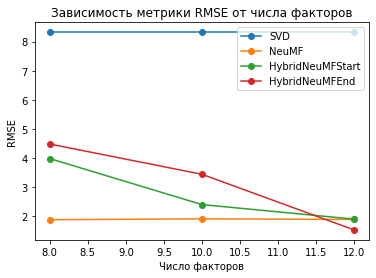

In [61]:
plt.plot(factors, svd_rmse, 'o-', label='SVD')
plt.plot(factors, nmf_rmse, 'o-', label='NeuMF')
plt.plot(factors, hybrid_start_rmse, 'o-', label='HybridNeuMFStart')
plt.plot(factors, hybrid_end_rmse, 'o-', label='HybridNeuMFEnd')
plt.legend(loc='upper right')
plt.xlabel('Число факторов')
plt.ylabel('RMSE')
plt.title('Зависимость метрики RMSE от числа факторов')
plt.show()

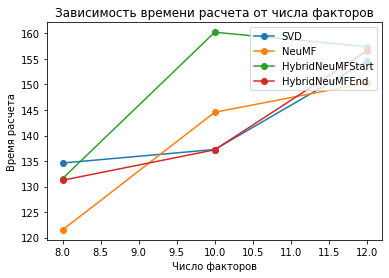

In [66]:
plt.plot(factors, svd_time, 'o-', label='SVD')
plt.plot(factors, nmf_time, 'o-', label='NeuMF')
plt.plot(factors, hybrid_start_time, 'o-', label='HybridNeuMFStart')
plt.plot(factors, hybrid_end_time, 'o-', label='HybridNeuMFEnd')
plt.legend(loc='upper right')
plt.xlabel('Число факторов')
plt.ylabel('Время расчета')
plt.title('Зависимость времени расчета от числа факторов')
plt.show()

**Выводы:**   
- Построены как классическая модель (SVD), так и нейосетевые (NeuMF, HybridNeuMF с присоединением фичей пользователей и товаров в начале и конце)  

- При увеличении количества факторов качество SVD не меняется (возможно, при большем скачке будут изменения), качества нейросетевых моделей улучшаются.

- При увеличении количества факторов время работы алгоритмов ожидаемо растет.

- На основе произведенного анализа можно сделать вывод, что оптимально использовать NeuMF, которая не сильно затратна по времени, но доставляет лучше качество, чем SVD. Для разворачивания гибридной модели NeuMF надо получше подумать над присоединяемыми признаки, тогда она, возможно, принесет больше прирост по качеству (ведь мы добавляем дополнительную информацию), а также стоит сделать модели поглубже и поучить больше эпох, чтобы выявить получше закономерности (но для этого уже нужна GPU).